In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Required Libraries

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_extract, col, isnan, when, count
from pyspark.sql.types import DoubleType

In [3]:
# Start Spark session
spark = SparkSession.builder.appName("LoanDataPrediction").getOrCreate()

In [4]:
# Load dataset
df = spark.read.csv("/content/drive/MyDrive/Lending_Data/lending_club_loan_two.csv", header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- loan_amnt: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- application_type: string (nullable 

In [6]:
df.show(5)

+-----------+----------+--------+-----------+-----+---------+---------------+----------+--------------+----------+-------------------+--------+-----------+------------------+--------------------+-----+----------------+--------+-------+---------+----------+---------+-------------------+----------------+--------+--------------------+--------------------+
|  loan_amnt|      term|int_rate|installment|grade|sub_grade|      emp_title|emp_length|home_ownership|annual_inc|verification_status| issue_d|loan_status|           purpose|               title|  dti|earliest_cr_line|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|application_type|mort_acc|pub_rec_bankruptcies|             address|
+-----------+----------+--------+-----------+-----+---------+---------------+----------+--------------+----------+-------------------+--------+-----------+------------------+--------------------+-----+----------------+--------+-------+---------+----------+---------+-------------------+----

In [7]:
df.describe()

DataFrame[summary: string, loan_amnt: string, term: string, int_rate: string, installment: string, grade: string, sub_grade: string, emp_title: string, emp_length: string, home_ownership: string, annual_inc: string, verification_status: string, issue_d: string, loan_status: string, purpose: string, title: string, dti: string, earliest_cr_line: string, open_acc: string, pub_rec: string, revol_bal: string, revol_util: string, total_acc: string, initial_list_status: string, application_type: string, mort_acc: string, pub_rec_bankruptcies: string, address: string]

#Feature Engineering

In [8]:
# 1. Extract zipcode from address
df = df.withColumn("zip_code", regexp_extract(col("address"), r'([A-Z]{2}\s*\d{5})$', 1))

In [9]:
df.printSchema()

root
 |-- loan_amnt: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- application_type: string (nullable 

#Data Cleaning

In [10]:
# 4. Drop rows with missing values in key columns
df = df.dropna(subset=['emp_length', 'mort_acc', 'pub_rec_bankruptcies'])

In [11]:
# 5. Filter out rows where important columns are zero
df = df.filter((col('annual_inc') != 0) &
               (col('revol_bal') != 0) &
               (col('revol_util') != 0))

In [12]:
# 6. Remove 'NONE' and 'OTHER' values from home_ownership
df = df.filter(~col('home_ownership').isin(['NONE', 'OTHER']))

In [13]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 339433
Number of columns: 28


#Plot Outliers

In [14]:
numeric_cols = df.columns[2:]
numeric_cols

['int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'dti',
 'earliest_cr_line',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'application_type',
 'mort_acc',
 'pub_rec_bankruptcies',
 'address',
 'zip_code']

In [15]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType, DoubleType # Import DoubleType

# List of columns that should be treated as numeric
true_numeric_cols = ['int_rate', 'installment', 'annual_inc', 'revol_bal', 'revol_util', 'pub_rec', 'total_acc', 'pub_rec_bankruptcies']

for column in true_numeric_cols:
    df = df.withColumn(column,f.col(column).cast(DoubleType()))

# Keep other columns as they are (including those incorrectly cast to int previously)
# The find_outliers function will filter for numeric types based on the schema after this casting

In [16]:
df.printSchema()

root
 |-- loan_amnt: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- application_type: string (nullable 

In [17]:
original_numerical_df = df.select(*true_numeric_cols).toPandas()

original_numerical_df.head(10)

,int_rate,installment,annual_inc,revol_bal,revol_util,pub_rec,total_acc,pub_rec_bankruptcies
0,11.44,329.48,117000.0,36369.0,41.8,0.0,25.0,0.0
1,11.99,265.68,65000.0,20131.0,53.3,0.0,27.0,0.0
2,10.49,506.97,43057.0,11987.0,92.2,0.0,26.0,0.0
3,6.49,220.65,54000.0,5472.0,21.5,0.0,13.0,0.0
4,17.27,609.33,55000.0,24584.0,69.8,0.0,43.0,0.0
5,13.33,677.07,86788.0,25757.0,100.6,0.0,23.0,0.0
6,5.32,542.07,125000.0,4178.0,4.9,0.0,25.0,0.0
7,11.14,426.47,46000.0,13425.0,64.5,0.0,15.0,0.0
8,10.99,410.84,103000.0,18637.0,32.9,0.0,40.0,0.0
9,16.29,928.40,115000.0,22171.0,82.4,0.0,37.0,0.0


In [18]:
from pyspark.sql.types import IntegerType, DoubleType # Import DoubleType

def find_outliers(df):
    from pyspark.sql.functions import col, when, lit, count, isnan # Import specific functions

    # Identifying the numerical columns in a spark dataframe
    # Filter for columns that are actually numeric types after casting
    numeric_columns = [column[0] for column in df.dtypes if column[1] in ('int', 'double')]

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:
        print(f"Processing column: {column}") # Add this print statement
        # Check if the column has non-null values before calculating quantiles
        if df.filter(col(column).isNotNull()).count() > 0:
            Q1_list = df.approxQuantile(column, [0.25], relativeError=0)
            Q3_list = df.approxQuantile(column, [0.75], relativeError=0)

            # Check if the quantile lists are not empty
            if Q1_list and Q3_list:
                Q1 = Q1_list[0]
                Q3 = Q3_list[0]

                # IQR : Inter Quantile Range
                IQR = Q3 - Q1

                #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
                less_Q1 =  Q1 - 1.5*IQR
                more_Q3 =  Q3 + 1.5*IQR

                isOutlierCol = 'is_outlier_{}'.format(column)

                df = df.withColumn(isOutlierCol,when((col(column) > more_Q3) | (col(column) < less_Q1), 1).otherwise(0))
            else:
                 # If quantiles cannot be calculated, mark all rows as not outliers for this column
                 isOutlierCol = 'is_outlier_{}'.format(column)
                 df = df.withColumn(isOutlierCol, lit(0))
        else:
            # If column has no non-null values, mark all rows as not outliers for this column
            isOutlierCol = 'is_outlier_{}'.format(column)
            df = df.withColumn(isOutlierCol, lit(0))


    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    if selected_columns: # Check if there are any outlier columns to sum
        # Need to sum the columns using a list comprehension with col
        df = df.withColumn('total_outliers', sum(col(c) for c in selected_columns))
    else:
        df = df.withColumn('total_outliers', lit(0))


    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [19]:
new_df = find_outliers(df)
new_df.show()

Processing column: int_rate
Processing column: installment
Processing column: annual_inc
Processing column: pub_rec
Processing column: revol_bal
Processing column: revol_util
Processing column: total_acc
Processing column: pub_rec_bankruptcies
+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+------------------+--------------------+-----+----------------+--------+-------+---------+----------+---------+-------------------+----------------+--------+--------------------+--------------------+--------+--------------+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|home_ownership|annual_inc|verification_status| issue_d|loan_status|           purpose|               title|  dti|earliest_cr_line|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|application_type|mort_acc|pub_rec_bankruptcies|             address|zip_code|total_ou

In [20]:
new_df_with_no_outliers = new_df.filter(new_df['total_Outliers']<=1)
new_df_with_no_outliers = new_df_with_no_outliers.select(*df.columns)

new_df_with_no_outliers.show()

+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+------------------+--------------------+-----+----------------+--------+-------+---------+----------+---------+-------------------+----------------+--------+--------------------+--------------------+--------+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|home_ownership|annual_inc|verification_status| issue_d|loan_status|           purpose|               title|  dti|earliest_cr_line|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|application_type|mort_acc|pub_rec_bankruptcies|             address|zip_code|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+------------------+--------------------+-----+----------------+--------+-------+---------+----------+-------

In [21]:
print(f"Number of rows: {new_df_with_no_outliers.count()}")
print(f"Number of columns: {len(new_df_with_no_outliers.columns)}")

Number of rows: 290078
Number of columns: 28


In [22]:
# Plotting the box for the dataset after removing the outliers

dataset_after_removing_outliers = new_df_with_no_outliers.toPandas()
dataset_after_removing_outliers.head(10)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,zip_code
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,0174 Michelle Gateway,
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,1076 Carney Fort Apt. 347,
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,87025 Mark Dale Apt. 269,
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,823 Reid Ford,
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,679 Luna Roads,
5,20000.0,36 months,13.33,677.07,C,C3,HR Specialist,10+ years,MORTGAGE,86788.0,...,0.0,25757.0,100.6,23.0,f,INDIVIDUAL,4.0,0.0,1726 Cooper Passage Suite 129,
6,18000.0,36 months,5.32,542.07,A,A1,Software Development Engineer,2 years,MORTGAGE,125000.0,...,0.0,4178.0,4.9,25.0,f,INDIVIDUAL,3.0,0.0,1008 Erika Vista Suite 748,
7,13000.0,36 months,11.14,426.47,B,B2,Office Depot,10+ years,RENT,46000.0,...,0.0,13425.0,64.5,15.0,f,INDIVIDUAL,0.0,0.0,USCGC Nunez,
8,18900.0,60 months,10.99,410.84,B,B3,Application Architect,10+ years,RENT,103000.0,...,0.0,18637.0,32.9,40.0,w,INDIVIDUAL,3.0,0.0,USCGC Tran,
9,26300.0,36 months,16.29,928.40,C,C5,Regado Biosciences,3 years,MORTGAGE,115000.0,...,0.0,22171.0,82.4,37.0,f,INDIVIDUAL,1.0,0.0,3390 Luis Rue,


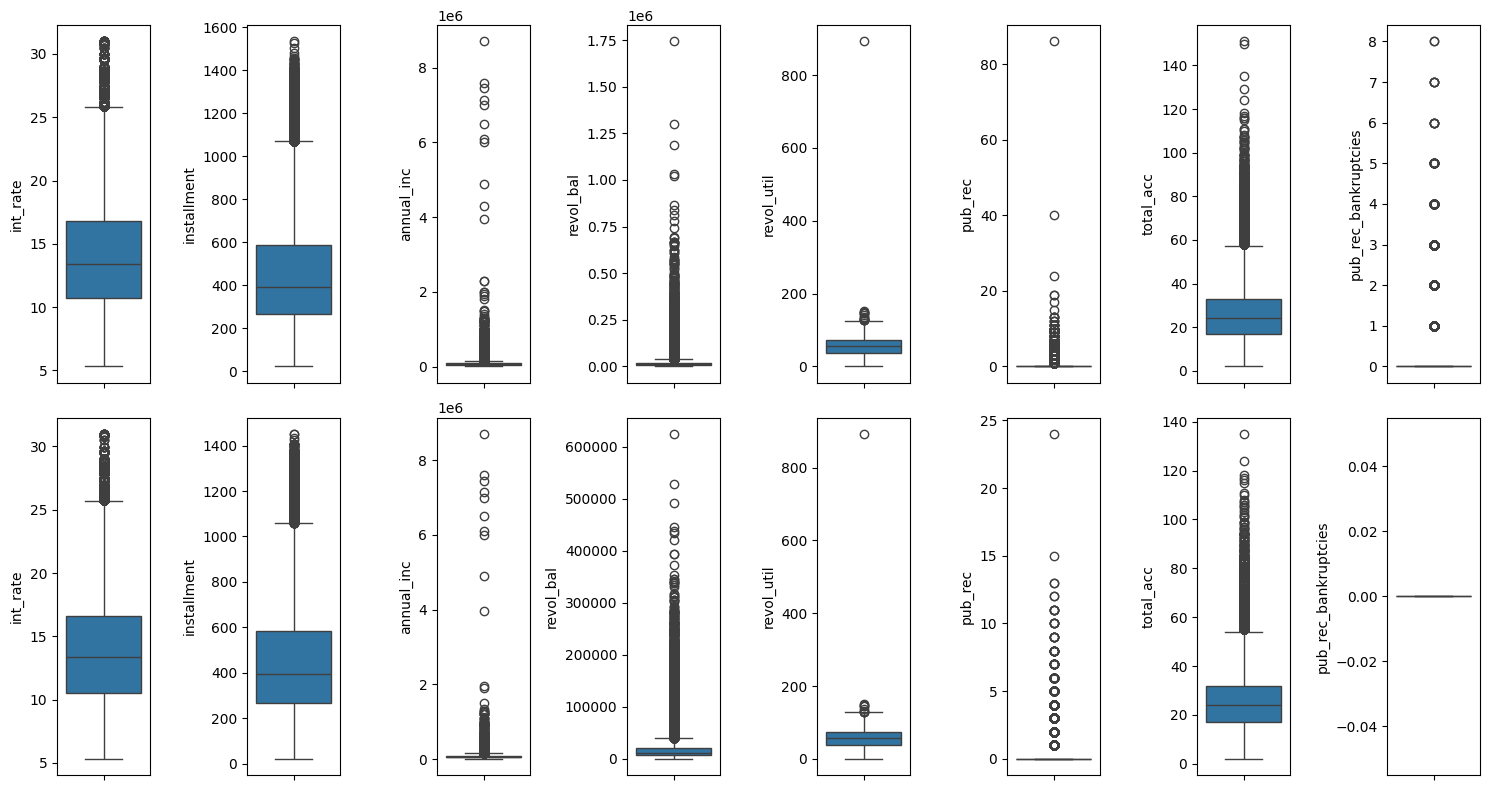

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the correct list of numeric columns
# true_numeric_cols is defined in cell TBpeMXrtcnr6
numeric_columns_for_plotting = true_numeric_cols

fig,ax = plt.subplots(2, len(numeric_columns_for_plotting),figsize=(15,8)) # Adjust the number of columns in subplots
for i,df in enumerate([original_numerical_df,dataset_after_removing_outliers]):

    for j, col in enumerate(numeric_columns_for_plotting): # Iterate through the correct list of columns
        sns.boxplot(data = df, y=col,ax=ax[i][j])

plt.tight_layout() # Add tight_layout to prevent overlapping titles/labels
plt.show() # Display the plots

In [24]:
print(f"Number of rows: {dataset_after_removing_outliers.count()}")
print(f"Number of columns: {len(dataset_after_removing_outliers.columns)}")

Number of rows: loan_amnt               290078
term                    290078
int_rate                290078
installment             290078
grade                   290078
sub_grade               290078
emp_title               287316
emp_length              290078
home_ownership          290078
annual_inc              290078
verification_status     290078
issue_d                 290078
loan_status             290078
purpose                 290078
title                   288823
dti                     290078
earliest_cr_line        290078
open_acc                290078
pub_rec                 290078
revol_bal               290078
revol_util              290078
total_acc               290078
initial_list_status     290078
application_type        290078
mort_acc                290078
pub_rec_bankruptcies    290078
address                 290078
zip_code                290078
dtype: int64
Number of columns: 28


In [25]:
#Undersampling of data

!pip install -U imbalanced-learn


In [26]:
# Undersampling of data using PySpark

# The 'new_df_with_no_outliers' is the PySpark DataFrame after outlier removal.
# Undersampling in PySpark requires a different approach than using libraries like imbalanced-learn,
# which are designed for Pandas DataFrames.
# A common approach in PySpark is to sample the majority class to match the minority class size.

# First, let's check the class distribution of the target variable 'loan_status'
class_counts = new_df_with_no_outliers.groupBy("loan_status").count()
class_counts.show()

# Assuming 'Fully Paid' is the majority class and 'Charged Off' is the minority class
# (You should verify this from the class_counts output)
majority_class_name = "Fully Paid" # Replace with the actual majority class name if different
minority_class_name = "Charged Off" # Replace with the actual minority class name if different

# Get the count of the minority class
minority_count = class_counts.filter(f.col("loan_status") == minority_class_name).select("count").collect()[0][0]

# Filter the DataFrame into majority and minority classes
majority_df = new_df_with_no_outliers.filter(f.col("loan_status") == majority_class_name)
minority_df = new_df_with_no_outliers.filter(f.col("loan_status") == minority_class_name)

# Undersample the majority class
# The fraction is calculated based on the ratio of minority count to majority count
majority_count_val = class_counts.filter(f.col("loan_status") == majority_class_name).select("count").collect()[0][0]
sampling_fraction = minority_count / majority_count_val

undersampled_majority_df = majority_df.sample(False, sampling_fraction, seed=42)

# Combine the undersampled majority class with the minority class
undersampled_df = undersampled_majority_df.unionAll(minority_df)

# Show the class distribution after undersampling
print("Class distribution after undersampling:")
undersampled_df.groupBy("loan_status").count().show()

# Now 'undersampled_df' is your PySpark DataFrame with balanced classes.
# You can proceed with model training using this DataFrame.

+-----------+------+
|loan_status| count|
+-----------+------+
| Fully Paid|232518|
|Charged Off| 57560|
+-----------+------+

Class distribution after undersampling:
+-----------+-----+
|loan_status|count|
+-----------+-----+
| Fully Paid|57919|
|Charged Off|57560|
+-----------+-----+



#Model Training and building

In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [28]:
# Step : Index target label
label_indexer = StringIndexer(inputCol="loan_status", outputCol="label", handleInvalid="keep")

# Step 2: Identify categorical and numerical columns using the PySpark DataFrame
categorical_cols = [field for (field, dtype) in undersampled_df.dtypes if dtype == "string" and field != "loan_status"]
numerical_cols = [field for (field, dtype) in undersampled_df.dtypes if dtype in ["int", "double", "float"]]

In [29]:
# Step : Split Data using the PySpark DataFrame
train_df, test_df = undersampled_df.randomSplit([0.8, 0.2], seed=42)

## One Hot Encoding

In [30]:
# Step : Index and encode categorical features
# Filter out categorical columns with less than 2 distinct values in the training data
categorical_cols_filtered = [col for col in categorical_cols if train_df.select(col).distinct().count() >= 2]

indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed", handleInvalid="keep") for column in categorical_cols_filtered]
encoders = [OneHotEncoder(inputCol=col + "_indexed", outputCol=col + "_ohe") for col in categorical_cols_filtered]

# Step 4: Combine all features
assembler_inputs = [col + "_ohe" for col in categorical_cols_filtered] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

## Logistic Regression Model

In [31]:
# Step : Model Definitions
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [32]:
# Step : Build Pipelines
lr_pipeline = Pipeline(stages=[label_indexer] + indexers + encoders + [assembler, lr])

In [33]:
lr_model = lr_pipeline.fit(train_df)

In [34]:
# Step : Predict on Test Data
lr_predictions = lr_model.transform(test_df)

In [35]:
# Step : Evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

lr_accuracy = evaluator.evaluate(lr_predictions)

In [36]:
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.6367


In [37]:
# Stop the existing Spark session if it's running
spark.stop()

# Start Spark session with increased memory allocation
spark = SparkSession.builder.appName("LoanDataPrediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()